In [1]:
import numpy as np
import os ; os.environ['HDF5_DISABLE_VERSION_CHECK']='2'

In [4]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

In [31]:
TRAIN_DIR = 'train_catdogs/train/'
# TEST_DIR = '../input/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog.' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat.' in i]

train_images = train_dogs[:1000] + train_cats[:1000]
test_images = train_dogs[1000:1500] + train_cats[1000:1500]

random.shuffle(train_images)
random.shuffle(test_images)

# test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
#     data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
#         data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 1000
Processed 250 of 1000
Processed 500 of 1000
Processed 750 of 1000


In [32]:
labels = []
for i in train_images:
    if 'dog.' in i:
        labels.append(1)
    else:
        labels.append(0)

In [33]:
test_labels = []
for i in test_images:
    if 'dog.' in i:
        test_labels.append(1)
    else:
        test_labels.append(0)

### And now we start !!

In [34]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

model = Sequential()

# model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, ROWS, COLS), activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(ROWS, COLS, 3), activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

C:\Users\miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(64, 64, 3..., activation="relu", padding="same")`
  import sys
C:\Users\miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  
C:\Users\miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
C:\Users\miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
C:\Users\miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(

In [35]:
nb_epoch = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

C:\Users\miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


In [22]:
predictions = model.predict(test, verbose=0)



I am 64.42% sure this is a Cat


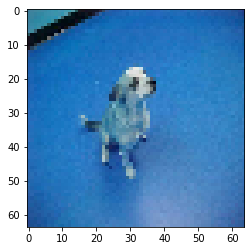

I am 71.94% sure this is a Dog


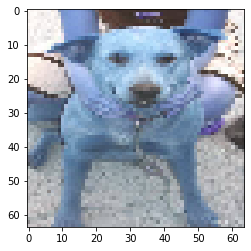

I am 96.47% sure this is a Cat


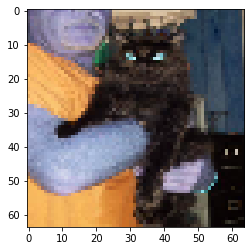

I am 99.05% sure this is a Cat


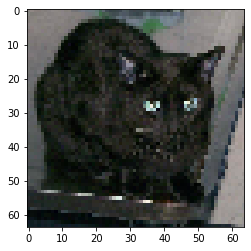

I am 94.11% sure this is a Cat


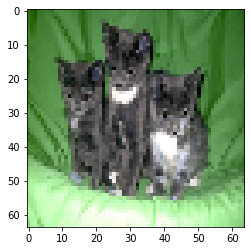

I am 99.95% sure this is a Cat


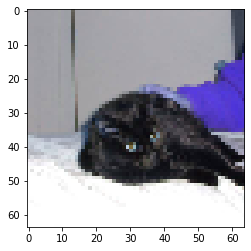

I am 73.66% sure this is a Dog


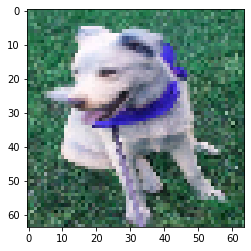

I am 50.70% sure this is a Dog


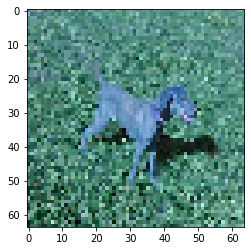

I am 67.27% sure this is a Dog


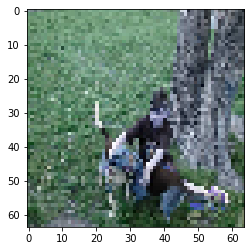

I am 59.39% sure this is a Cat


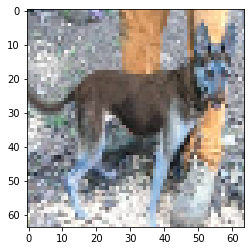

In [36]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i])
    plt.show()
